<a href="https://colab.research.google.com/github/woneuy01/NLP_Jon/blob/master/convolutional_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Sentiment Classifier

In this notebook, we build a *convolutional* neural net to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [0]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

#### Set hyperparameters

In [0]:
# output directory name:
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # drop out 20% of embedding layers

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

#### Load data

In [0]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17465344/17464789 [==============================] - 1s 0us/step


#### Preprocess data

In [0]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [0]:
model = Sequential()

#first hidden layer:
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) # 5000 words 64 diminsional vectors max_review_length =400
model.add(SpatialDropout1D(drop_embed))

#second hidden layer:Conv1D we have 1D input
model.add(Conv1D(n_conv, k_conv, activation='relu')) #n_conv=256 k_conv=3 look 3 words in sequence 단어 3개씩 연달아서 본다
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

#third hidden layer,Dense layer is common in CNN but not for RNN
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

#output layer sigmoid: binary 0% upto 100%
model.add(Dense(1, activation='sigmoid'))

#dense layer had much less parameter becuase globalMaxPooling results smaller output

In [0]:
model.summary() 
#embedding 5000 * 64 =320000
#conv1d param 256(n_conv)*64(n_dimen)*3(k_conv) +256(n_conv)
#dense(Dense) 256(neurons)*256(flatten) +256 bias 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

#### Configure model

In [0]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [0]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [0]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 6s 29ms/step - loss: 0.4731 - accuracy: 0.7518 - val_loss: 0.2949 - val_accuracy: 0.8768
Epoch 2/4
196/196 [==============================] - 5s 27ms/step - loss: 0.2554 - accuracy: 0.8949 - val_loss: 0.2577 - val_accuracy: 0.8942
Epoch 3/4
196/196 [==============================] - 5s 27ms/step - loss: 0.1860 - accuracy: 0.9286 - val_loss: 0.2566 - val_accuracy: 0.8959
Epoch 4/4
196/196 [==============================] - 5s 27ms/step - loss: 0.1331 - accuracy: 0.9514 - val_loss: 0.2915 - val_accuracy: 0.8887


#### Evaluate

In [0]:
model.load_weights(output_dir+"/weights.03.hdf5") # load 3rd epoch

In [0]:
y_hat = model.predict_proba(x_valid)

Instructions for updating:
Please use `model.predict()` instead.


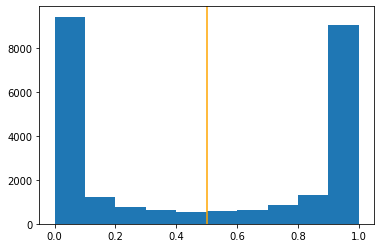

In [0]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [0]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0) # auc increased from 92 to 96.1%

'96.12'